In [ ]:
!nvidia-smi

Sat Dec 27 06:01:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             30W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### check gpu accesss with pytorch

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# count number of devices
torch.cuda.device_count()

1

## putting tensors (and models) on gpu

beacuse gpu give faster computations

In [ ]:
# create tensor
tensor = torch.tensor([1,2,3])

# by default tensor is on cpu

# Move tensor to the device
tensor_on_gpu = tensor.to(device)

print(tensor, tensor.device)
print(tensor_on_gpu, tensor_on_gpu.device)

tensor([1, 2, 3]) cpu
tensor([1, 2, 3], device='cuda:0') cuda:0


In [ ]:
# moving tensors back to cpu as numpy etc runs on cpu
# move back to cpu and then convert
tensor_on_gpu.cpu().numpy()

array([1, 2, 3])

### Pytorch workflow

we wil cover
1. data ( prepare and load)
2. build model
3. fit model to data
4. make predictions ( inference)
5. save and load model
6. put it all together

In [ ]:
from torch import nn # nn contain all pytorch building blocks for nn
# basic blocks like containers , conv layers , graph etc.
import matplotlib.pyplot as plt

torch.__version__

'2.9.0+cu126'

## 1. Data (prepare and load)

# data can be anything  like excel , images , text , audio , videos etc
# ML is game of 2 parts
#1. Big data into numerical reperesentation
#2.Build a model to learn patterns into that numerical representation

# lets use linear regression formula to make st. line with known parameter





In [ ]:
# create known parameter
weight = 0.7
bias = 0.3

# create data
start=0
end=1
step=0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y=weight * X + bias

X[:10] , y[:10] , len(X) , len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets ( most important concepts in ML)

lets create a training and test data set with our data



In [ ]:
# create test and train split
train_split=int(0.8*len(X))
X_train , y_train = X[:train_split],y[:train_split]
X_test , y_test = X[train_split:],y[train_split:]

# scikit learn test and train split is quite popular

len(X_train) , len(X_test) , len(y_train) , len(y_test)

(40, 10, 40, 10)

In [ ]:
# how we can better visualise data
# here's where data explorer motto comes in
# visualize , visualize , visualize

def plot_predictions(train_data=X_train , train_labels = y_train , test_data=X_test , test_labels=y_test , predictions=None):
  """ Plots trainng data , test data and compares predictions"""
  plt.figure(figsize=(10,7))

  # plot traing data in blue
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")

  # plot test data in green
  plt.scatter(test_data , test_labels , c="g" , s=4 , label="Testing_data")

  if predictions is not None:
    #plot the predictions
    plt.scatter(test_data , predictions , c="r" , s=4 , label="Predictions")

  # show the legend
  plt.legend(prop={"size":14});

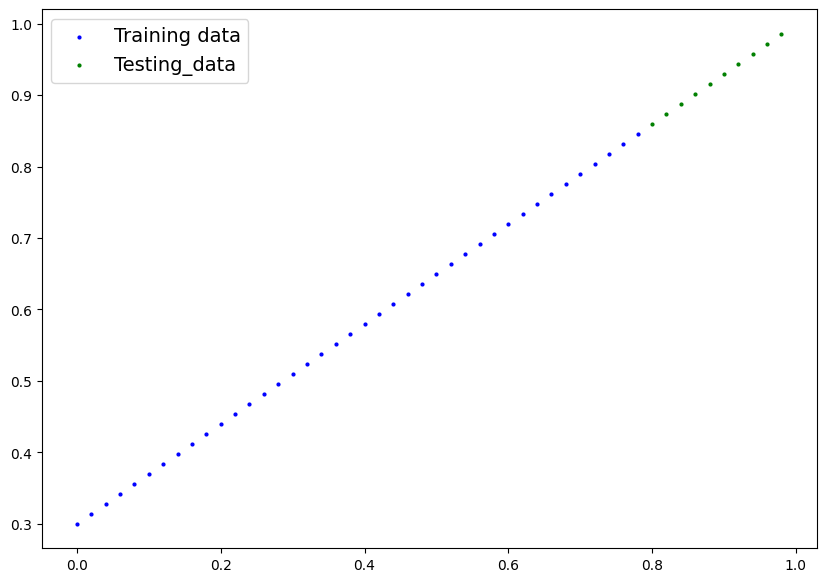

In [ ]:
plot_predictions()

# Build our pytorch model

what do we do?
start with random values (bias , weight)
look at training data and adjust rand values to better represent the ideal values

This is done through two main algo.
1.Gradient descent
2.Back propogation

In [ ]:
from torch import nn
# create linear regression model class
class LinearRegressionModelV1(nn.Module): # almost everything in pytorch inherits from this nn.mo
  def __init__(self):
    super().__init__()
    self.weights=nn.Parameter(torch.rand(1,requires_grad=True , dtype=torch.float))
    self.bias=nn.Parameter(torch.rand(1,requires_grad=True , dtype=torch.float))

  # forward method to find computatipn in model
  def forward(self,x:torch.Tensor) -> torch.Tensor:  # x is input
    return self.weights * x + self.bias

### Pytorch model building essentials

1. torch.nn - contains all for building computational graphs ( nn can be considered a computational graph)

2.torch.nn.Parameter - what parameteres should our model should try an drun , often a pytorch layerfrom torch.nn will set these for us

3. torch.nn.Module - base class for all nn modules , if you sub class it , you should overwrite forward
4. torch.optim - where optimisers live , help with gradient descent
5. def forward() - all nn.Module subclasses are required you to overwrite forward() , this method defines what happens in forward computation



### Checking contents of pytorch model

Now we have created model , lets see what's inside using   ".parameters()"

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create a linear regression model's instance
model_1 = LinearRegressionModelV1()
model_1

# check parameters
list(model_1.parameters())


[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [ ]:
#  list named parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

### Making Prediction using 'torch.inference.mode()'
 To check model's predective power , Lets see how it predicts 'y_test' based on 'X_test'
When we pass data through our model , its going to run forward() method


In [ ]:
X_test , y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [ ]:
# Make predictions with model
with torch.inference_mode() :
  y_preds=model_1(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

 Using inference model to skip tracking gradient as we are not training and dont need to keep track of gradient also we are not updating the model weights
previously people used to use torch.nograd()

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

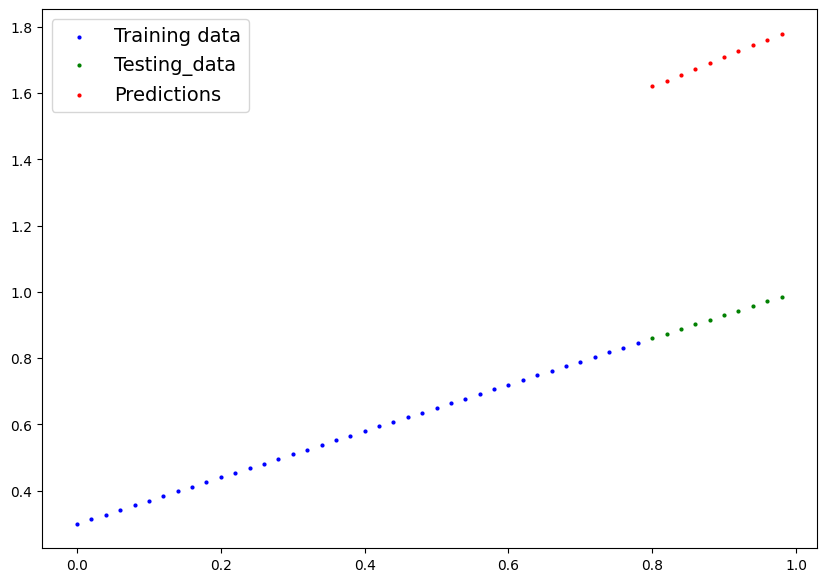

In [ ]:
plot_predictions(predictions=y_preds)

## Now we need to train the model as there is lot of parity between test and predictions

## Train model ( Loss Function )
The whole traning is to move model from unknown to known parameters
                       or
Poor representation of data to better representation

One way to measure how poor / wrong our predictions are use the loss function

Note : loss funcn also called cost function / criterion in different areas

Loss Function: A function to measure how wrong our predictions to ideal results

Optimizer : Take into account the loss of a model and adjust the model's parmaters ( weight , bias etc) to improve the loss function.

Specifically for PyTorch , we need:
* A training loop
* A testing loop


In [ ]:
# check out model parameters
model_1.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [ ]:
# setup a loss function
loss_fn=nn.L1Loss()

# L1Loss accounts for Mean Absolute Error

# setup an optimizer , btw loss fn and optimizer comes in same package
# SGD is stochastic gradient descent , lr is learning rate
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [ ]:
loss_fn , optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

### Building a Training loop (and a testing loop)

# Things needed for a training loop:

# 1. Loop through data
# 2. Forward pass (data moving through our model's forward() functions) , also called forward propogation
# 3. calculate loss (compare forward pass predictions to truth labels)
# 4. optimizer zero grad
# 5. loss backward - move backwards through network to calculate gradients of each of the Parameters w.r.t loss (back propogation)
# 6. optimizer step - adjust model's parameters to try and improve loss

In [ ]:
# An epoch is a one loop thru the data..
epochs=200

# Track different values
epoch_count=[]
loss_values=[]
test_loss_values=[]


### Training
# loop thru the data
for epoch in range(epochs):
  # put model in training mode
  model_1.train()

  #forward pass
  y_pred=model_1(X_train)

  loss = loss_fn(y_pred , y_train) # calculate loss

  optimizer.zero_grad() #it makes grad zero for the new loop cycle if thr value chnages in earlier cycle

  loss.backward()

  optimizer.step() #perform gradient descent

  ### Testing
  model_1.eval() # turns off different settings not needed for training and testing
  with torch.inference_mode(): # turns off gradient tracking
    test_pred=model_1(X_test) # forward pass

    test_loss=loss_fn(test_pred , y_test) # calculate loss

  # Print out what's happening only every 10 epochs
  if epoch % 10 == 0 :
    epoch_count.append(epoch)
    loss_values.append(loss.item()) # .item() to get a Python number from a tensor
    test_loss_values.append(test_loss.item()) # .item() to get a Python number from a tensor
    print(f"Epoch : {epoch} | Loss : {loss} | Test loss: {test_loss}")
    print(model_1.state_dict())

Epoch : 0 | Loss : 0.6860889196395874 | Test loss: 0.7637526988983154
OrderedDict({'weights': tensor([0.8784]), 'bias': tensor([0.9050])})
Epoch : 10 | Loss : 0.5708791017532349 | Test loss: 0.6290428042411804
OrderedDict({'weights': tensor([0.8394]), 'bias': tensor([0.8050])})
Epoch : 20 | Loss : 0.45566922426223755 | Test loss: 0.4943329691886902
OrderedDict({'weights': tensor([0.8004]), 'bias': tensor([0.7050])})
Epoch : 30 | Loss : 0.34045934677124023 | Test loss: 0.35962313413619995
OrderedDict({'weights': tensor([0.7614]), 'bias': tensor([0.6050])})
Epoch : 40 | Loss : 0.2252494841814041 | Test loss: 0.2249133139848709
OrderedDict({'weights': tensor([0.7224]), 'bias': tensor([0.5050])})
Epoch : 50 | Loss : 0.1100396141409874 | Test loss: 0.09020347893238068
OrderedDict({'weights': tensor([0.6834]), 'bias': tensor([0.4050])})
Epoch : 60 | Loss : 0.009724985808134079 | Test loss: 0.020998019725084305
OrderedDict({'weights': tensor([0.6539]), 'bias': tensor([0.3200])})
Epoch : 70 | 

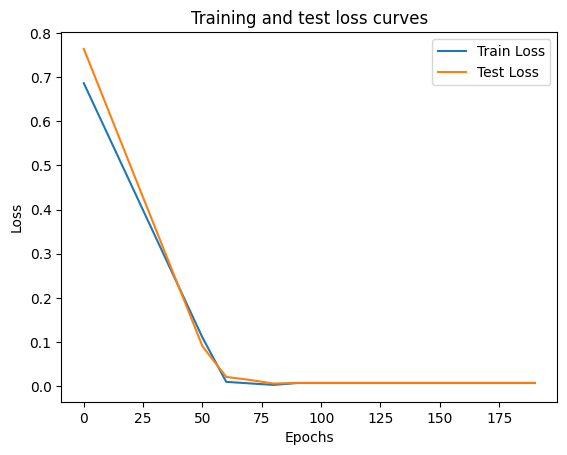

In [ ]:
plt.plot(epoch_count , loss_values, label="Train Loss")
plt.plot(epoch_count , test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new=model_1(X_test)


In [ ]:
model_1.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

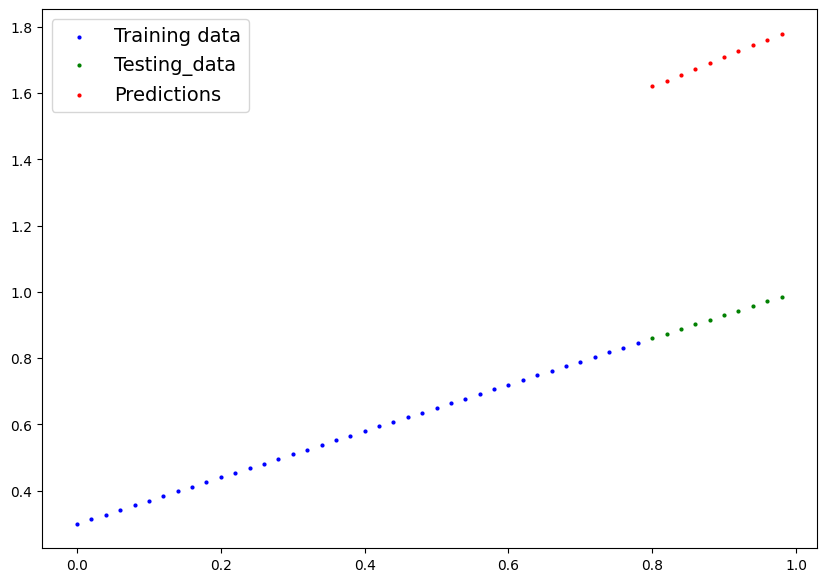

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
weight , bias


(0.7, 0.3)

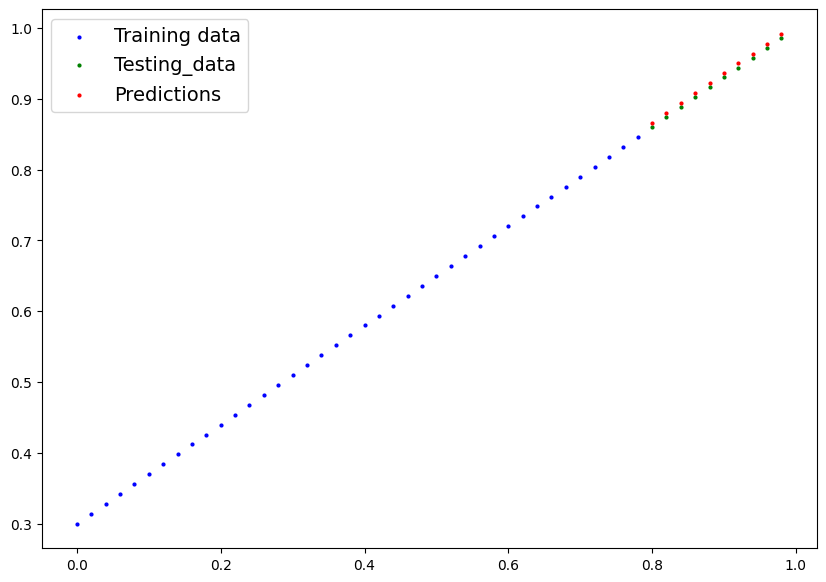

In [ ]:
plot_predictions(predictions=y_preds_new)

In [ ]:
model_1.state_dict() # should be close to 0.7 , 0.3

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

## Saving a model in Pytorch

3 main methods:
1. 'torch.save()' - allows to save a pyTorch object in Python's pickle format
2. 'torch.load()' - load a save PyTorch object
3.'torch.nn.Module.load_state_dict()'
  -allows to load a model's saved stste dict


In [160]:
# Saving out PyTorch Model
from pathlib import Path

# 1. Create Model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#2 . Create model save path
MODEL_NAME = "01_pytorch_workflow_mode.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# 3. save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict() , f=MODEL_SAVE_PATH)


Saving model to : models/01_pytorch_workflow_mode.pth


In [162]:
!ls -l models


total 4
-rw-r--r-- 1 root root 2093 Dec 27 06:34 01_pytorch_workflow_mode.pth


## Loading a PyTorch Model

since we saved our model's 'state_dict()' rather than entire model , we will create a new instance of our model class and load the saved state_dict()

In [163]:
model_1.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [166]:
# To load in a saved state dict , we have to instantiate a new model class
loaded_model_1 = LinearRegressionModelV1()

# load the saved state dict of model_1 (this will update the new instance with updated parameter)
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_1.state_dict()


OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [168]:
# Make some predictions

loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

loaded_model_1_preds

tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

In [175]:
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)

y_preds


tensor([[0.8661],
        [0.8801],
        [0.8940],
        [0.9080],
        [0.9220],
        [0.9359],
        [0.9499],
        [0.9638],
        [0.9778],
        [0.9917]])

In [176]:
y_preds == loaded_model_1_preds


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])